# Calibration Tutorial - Crane, OR - Irrigated Flux Plot

## Step 1: Getting the Data

Note: Step 1 can be bypassed if necessary. Just unzip `tutorials/3_Crane/data/prepped_input.zip` and proceed to Step 2.

This tutorial is going to focus on calibrating the SWIM for a single unirrigated plot, which is a 150 meter buffer around FluxNet's US-Fpe eddy covariance station. This will be interesting because the flux station has independent observations of both meteorology and the ET flux itself. Let's see if we can improve upon our *a priori* estimates of soil hydraulic parameters and our default parameterization of the snow and Kcb model (function of NDVI).

This notebook bases all it's work on the polygons in `tutorials/3_Crane/data/gis/flux_fields.shp`.

This notebook is easily modified to get all the flux station's input data; just remove the `select` or like arguments (`field_select`/`target_fields`, etc.) so it doesn't run on only our focus, the station at Crane. This would additionally require downloading the entire bias correction GeoTIFF data set, from the Earth Engine asset folder `projects/ee-dgketchum/assets/swim/gridmet_bias_correction`.

We won't cover the details of compiling data for the modeling run unless it is a different approach than what we did in the first tutorial, `1_Boulder`. Revisit that tutorial's steps 2-4 for further explanation of what we speed through below. Let's get started:

In [42]:
import os
import sys
import json

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ee

root = os.path.abspath('../../..')
sys.path.append(root)

from data_extraction.ee.ee_utils import is_authorized
from data_extraction.ee.etf_export import sparse_sample_etf
from data_extraction.ee.ndvi_export import sparse_sample_ndvi
from data_extraction.ee.snodas_export import sample_snodas_swe
from data_extraction.snodas.snodas import create_timeseries_json
from data_extraction.ee.ee_props import get_irrigation, get_ssurgo

from utils.google_bucket import list_and_copy_gcs_bucket

from data_extraction.gridmet.gridmet import get_gridmet_corrections
from data_extraction.gridmet.gridmet import download_gridmet

from prep.field_properties import write_field_properties
from prep.field_timeseries import join_daily_timeseries
from prep.landsat_sensing import sparse_landsat_time_series, join_remote_sensing, detect_cuttings

from prep.field_timeseries import join_daily_timeseries
from prep.prep_plots import prep_fields_json

# Set matplotlib to display inline
%matplotlib inline

command = '/home/dgketchum/google-cloud-sdk/bin/gsutil'
bucket = 'wudr'

data = os.path.join(root, 'tutorials', '4_Flux_Network', 'data')
shapefile_path = os.path.join(data, 'gis', 'flux_fields.shp')
gdf = gpd.read_file(shapefile_path)
gdf.shape

FEATURE_ID = 'field_1'


In [43]:
gdf.columns

Index(['field_1', 'field_2', 'field_3', 'field_4', 'field_5', 'field_6',
       'field_7', 'field_8', 'field_9', 'field_10', 'field_11', 'field_12',
       'field_13', 'field_14', 'AmeriFlux', 'field_16', 'field_17', 'field_18',
       'field_19', 'field_20', 'LAT', 'LON', 'FID', 'geometry'],
      dtype='object')

The shapefile is derived from John Volk's work, which is documented here: https://www.sciencedirect.com/science/article/pii/S0168192323000011

Their paper used a sophisticated method for determining the area on the ground that contibutes to the flux observation. Instead of using their footprints, we're going to use a 150-m buffer around the station for simplicity. We're just going to use one station from the dataset, US-FPe.

In [44]:
gdf.index = gdf[FEATURE_ID]
gdf['por_days'] = gdf['field_5'].apply(lambda x: (pd.to_datetime(x.split('-')[1], format='%m/%Y') - pd.to_datetime(x.split('-')[0], format='%m/%Y')).days if '-' in x else None)
gdf

,field_1,field_2,field_3,field_4,field_5,field_6,field_7,field_8,field_9,field_10,...,field_16,field_17,field_18,field_19,field_20,LAT,LON,FID,geometry,por_days
field_1,,,,,,,,,,,,,,,,,,,,,
US-A32,US-A32,Grasslands,OK,AmeriFlux,06/2015-06/2017,0.90,36.819268,-97.819772,335.0,Hay pasture,...,Lara Kueppers,PI,Lawrence Berkeley National Laboratory,lmkueppers@lbl.gov,ARM-SGP Medford hay pasture,36.819,-97.820,US-A32,"POLYGON ((-160660.067 1532045.881, -160667.409...",731
US-A74,US-A74,Croplands,OK,AmeriFlux,01/2016-10/2017,0.92,36.808464,-97.548854,337.0,Sorghum,...,Lara Kueppers,PI,Lawrence Berkeley National Laboratory,lmkueppers@lbl.gov,ARM SGP milo field,36.808,-97.549,US-A74,"POLYGON ((-136741.55 1530411.259, -136748.892 ...",639
US-ADR,US-ADR,Shrublands,NV,AmeriFlux,05/2011-05/2017,0.92,36.765278,-116.693333,842.0,Greasewood,...,Michael Moreo,PI,U.S. Geological Survey,mtmoreo@usgs.gov,Amargosa Desert Research Site (ADRS),36.765,-116.693,US-ADR,"POLYGON ((-1815484.923 1722917.858, -1815492.2...",2192
US-AR1,US-AR1,Croplands,OK,AmeriFlux,06/2009-12/2012,1.09,36.426700,-99.420000,611.0,Planted Switchgrass,...,Dave Billesbach,PI,University of Nebraska,dbillesbach1@unl.edu,ARM USDA UNL OSU Woodward Switchgrass 1,36.427,-99.420,US-AR1,"POLYGON ((-303604.982 1491993.98, -303612.323 ...",1279
US-ARb,US-ARb,Grasslands,OK,AmeriFlux,03/2005-10/2006,1.01,35.549700,-98.040200,424.0,Native tallgrass prairie,...,Margaret Torn,PI,Lawrence Berkeley National Laboratory,mstorn@lbl.gov,ARM Southern Great Plains burn site- Lamont,35.550,-98.040,US-ARb,"POLYGON ((-183188.322 1390288.5, -183195.664 1...",579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UOVLO,UOVLO,Shrublands,NV,USGS NWSC,07/1998-09/2000,NA,37.045000,-116.709000,1177.0,Greasewood,...,None,None,None,None,None,37.045,-116.709,UOVLO,"POLYGON ((-1810061.958 1753817.29, -1810069.29...",793
UOVMD,UOVMD,Grasslands,NV,USGS NWSC,12/1998-09/2000,NA,37.047000,-116.712000,1175.0,Salt Grass,...,None,None,None,None,None,37.047,-116.712,UOVMD,"POLYGON ((-1810271.572 1754093.24, -1810278.91...",640
UOVUP,UOVUP,Shrublands,NV,USGS NWSC,01/1998-09/2000,NA,37.064000,-116.695000,1198.0,Wolfberry/Rabbitbrush,...,None,None,None,None,None,37.064,-116.695,UOVUP,"POLYGON ((-1808397.64 1755629.405, -1808404.98...",974


/tmp/ipykernel_12307/2957876030.py:9: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




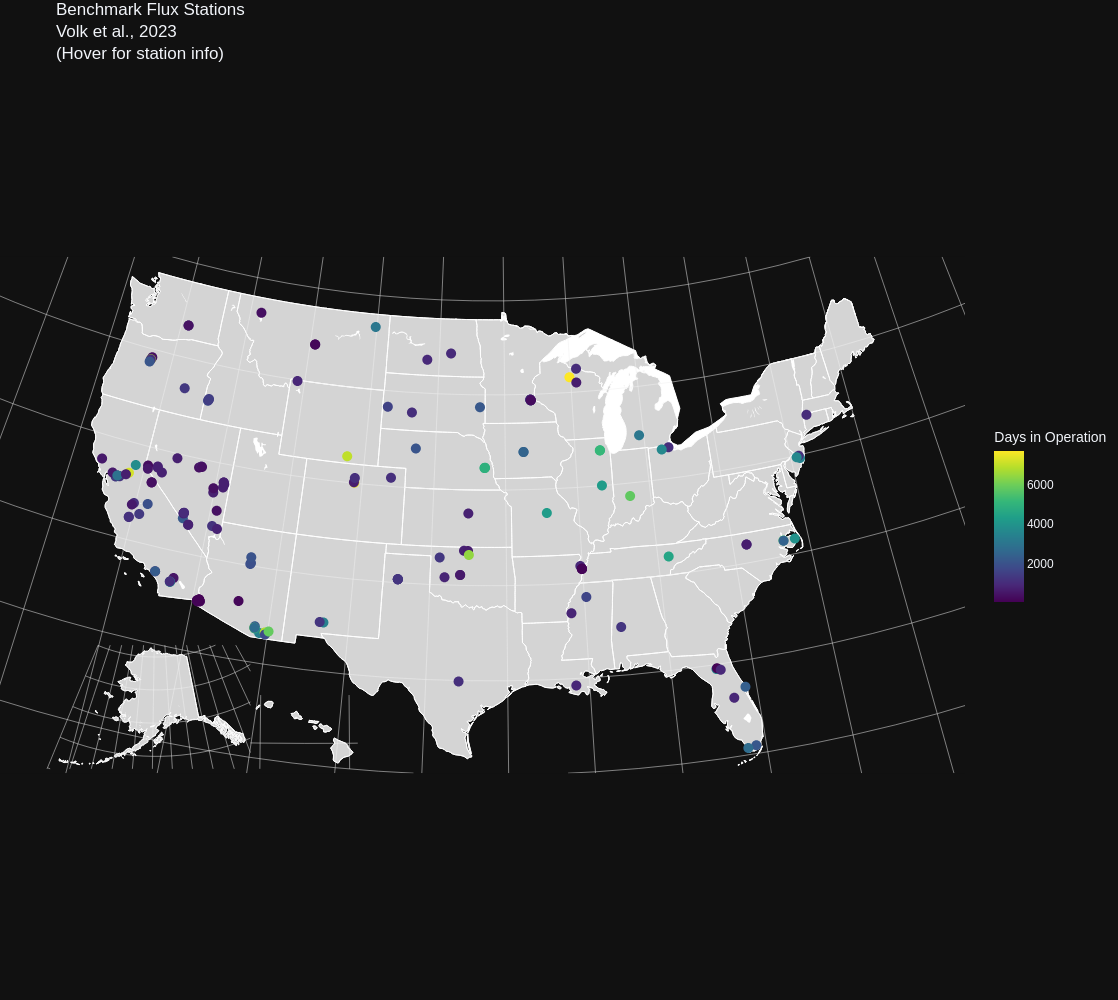

In [45]:
import plotly.graph_objects as go

gdf_proj = gdf.to_crs(epsg=4326)

gdf_proj['label'] = gdf_proj['field_1'].astype(str) + '<br>' + \
                    gdf_proj['field_2'].astype(str) + '<br>' + \
                    gdf_proj['field_5'].astype(str)

centroids = gdf_proj.geometry.centroid

fig = go.Figure(go.Scattergeo(
    lon=centroids.x,
    lat=centroids.y,
    text=gdf_proj['label'],
    mode='markers',
    marker=dict(
        size=10,
        color=gdf_proj['por_days'],
        colorscale='Viridis',
        colorbar=dict(title='Days in Operation', len=0.2)  # Adjust colorbar length
    )
))

fig.update_layout(
    title='Benchmark Flux Stations<br>Volk et al., 2023<br>(Hover for station info)',
    geo_scope='usa',
    margin={"r": 0, "t": 30, "l": 0, "b": 0},
    template="plotly_dark",
    height=1000,  # Increase map height
    width=1000,
    geo=dict(
        scope='usa',
        projection_type="albers usa",
        showland=True,
        landcolor="rgb(212, 212, 212)",
        subunitcolor="rgb(255, 255, 255)",
        countrycolor="rgb(255, 255, 255)",
        showlakes=True,
        lakecolor="rgb(255, 255, 255)",
        showsubunits=True,
        showcountries=True,
        resolution=50,
        lonaxis=dict(
            showgrid=True,
            gridwidth=0.5,
            range=[-130.0, -70.0],
            dtick=5
        ),
        lataxis=dict(
            showgrid=True,
            gridwidth=0.5,
            range=[20.0, 60.0],
            dtick=5
        )
    ),
    mapbox_style="satellite-streets"
)

fig.show()

Instead of using the `clustered_sample_etf` like in the first tutorial, we're going to use `sparse_sample_etf` since we only have one station. We would use the same if we selected from more stations, as they are spread out. The`sparse_sample_etf` function accepts a shapefile.

We can use the `select` argument and use a list of our single feature ID to only export that data. 

Note: In this tutorial, you can modify the function calls to export data for all the flux stations easily; just remove the `select` arguments, and it will get all the data needed for the validation tutorial.

### 1. Earth Engine Remote Sensing Extracts

In [46]:
landsat = os.path.join(data, 'landsat')
extracts = os.path.join(landsat, 'extracts')
tables = os.path.join(landsat, 'tables')

if not os.path.isdir(tables):
    os.makedirs(tables, exist_ok=True)

is_authorized()

Authorized


In [19]:
# The extraction
bucket = 'wudr'

for src in ['ndvi', 'etf']:
    for mask in ['inv_irr', 'irr']:
        
        dst = os.path.join(data, 'landsat', 'extracts', src, mask)
        
        if not os.path.exists(dst):
            os.makedirs(dst, exist_ok=True)

        if src == 'etf':
            print(src, mask)
            sparse_sample_etf(shapefile_path, bucket, debug=False, mask_type=mask, check_dir=dst, 
                              start_yr=1987, end_yr=2022, feature_id=FEATURE_ID)
        if src == 'ndvi':
            print(src, mask)
            sparse_sample_ndvi(shapefile_path, bucket, debug=False, mask_type=mask, check_dir=dst, 
                               start_yr=1987, end_yr=2022, feature_id=FEATURE_ID)

ndvi inv_irr


Processing Fields: 100%|██████████████████████| 161/161 [00:04<00:00, 33.62it/s]


NDVI: Exported 6, skipped 5790 files found in /home/dgketchum/PycharmProjects/swim-rs/tutorials/4_Flux_Network/data/landsat/extracts/ndvi/inv_irr
ndvi irr


Processing Fields: 100%|████████████████████| 161/161 [00:00<00:00, 3775.06it/s]


NDVI: Exported 0, skipped 5796 files found in /home/dgketchum/PycharmProjects/swim-rs/tutorials/4_Flux_Network/data/landsat/extracts/ndvi/irr
etf inv_irr


Processing Fields: 100%|████████████████████| 161/161 [00:00<00:00, 4313.28it/s]


ETf: Exported 0, skipped 3348 files found in /home/dgketchum/PycharmProjects/swim-rs/tutorials/4_Flux_Network/data/landsat/extracts/etf/inv_irr
etf irr


Processing Fields: 100%|████████████████████| 161/161 [00:00<00:00, 4332.85it/s]

ETf: Exported 0, skipped 3348 files found in /home/dgketchum/PycharmProjects/swim-rs/tutorials/4_Flux_Network/data/landsat/extracts/etf/irr


In [21]:
# Copy to local directory; Note the flux-station specific for-loop
# use the following for a full station network extract:
stations = gdf[FEATURE_ID].tolist()

# # use this for just Crane
# stations = [selected_feature]

for src in ['ndvi', 'etf']:
    for mask in ['inv_irr', 'irr']:
        for station in stations:
            dst = os.path.join(data, 'landsat', 'extracts', src, mask)
            if not os.path.isdir(dst):
                os.makedirs(dst, exist_ok=True)
            glob_ = f'{src}_{station}_{mask}'
            list_and_copy_gcs_bucket(command, bucket, dst, glob=glob_, dry_run=False, overwrite=False)

Copying Files from wudr: 100%|███████████████| 36/36 [00:00<00:00, 88664.09it/s]


Copied 0 of 36; skipped 36 existing files


Copying Files from wudr: 100%|███████████████| 32/32 [00:00<00:00, 64839.48it/s]


Copied 0 of 32; skipped 32 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 100%|████████████████████| 6/6 [00:09<00:00,  1.50s/it]


Copied 6 of 6; skipped 0 existing files


Copying Files from wudr: 100%|███████████████| 33/33 [00:00<00:00, 87491.80it/s]


Copied 0 of 33; skipped 33 existing files


Copying Files from wudr: 100%|███████████████| 10/10 [00:00<00:00, 34435.99it/s]


Copied 0 of 10; skipped 10 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


Copying Files from wudr: 0it [00:00, ?it/s]


Copied 0 of 0; skipped 0 existing files


KeyboardInterrupt: 

In [22]:
# Write to interpolated time series
types_ = ['inv_irr', 'irr']
sensing_params = ['ndvi', 'etf']

for mask_type in types_:

    for sensing_param in sensing_params:
        
        yrs = [x for x in range(1987, 2024)]

        ee_data, src = None, None

        ee_data = os.path.join(extracts, sensing_param, mask_type)
        src = os.path.join(tables, '{}_{}_{}.csv'.format('calibration', sensing_param, mask_type))
        src_ct = os.path.join(tables, '{}_{}_{}_ct.csv'.format('calibration', sensing_param, mask_type))

        sparse_landsat_time_series(shapefile_path, ee_data, yrs, src, src_ct, feature_id=FEATURE_ID, select=None)

/home/dgketchum/PycharmProjects/swim-rs/tutorials/4_Flux_Network/data/landsat/extracts/ndvi/inv_irr


Processing Time Series:  46%|████████▋          | 17/37 [00:32<00:37,  1.90s/it]


ValueError: Shape of passed values is (79, 78), indices imply (79, 1)

In [23]:
remote_sensing_file = os.path.join(landsat, 'remote_sensing.csv')
join_remote_sensing(tables, remote_sensing_file)

etf_inv_irr_ct
ndvi_inv_irr_ct
etf_inv_irr
etf_inv_irr_ct
etf_irr_ct
ndvi_irr
etf_irr
etf_irr_ct
etf_inv_irr
ndvi_inv_irr
ndvi_irr_ct
ndvi_inv_irr_ct
ndvi_inv_irr
etf_irr
ndvi_irr_ct
ndvi_irr


### 2. Other Earth Engine Extracts

In [47]:
snow_dst = os.path.join(data, 'snodas', 'extracts')
if not os.path.isdir(snow_dst):
    os.makedirs(snow_dst, exist_ok=True)

In [28]:
fields =  'users/dgketchum/fields/flux'
sample_snodas_swe(fields, bucket, debug=False, check_dir=snow_dst, overwrite=False, feature_id=None)

Extracting SNODAS: 100%|██████████████████| 240/240 [00:00<00:00, 187594.66it/s]

SNODAS exported 0, skipped 240 existing files


In [34]:
# Since we're getting Flux stations from the Eastern US, outside coverage of IrrMapper, we'll get LANID where necessary
description = 'calibration_irr'
get_irrigation(fields, description, debug=False, selector=FEATURE_ID, lanid=True)
description = 'calibration_ssurgo'
get_ssurgo(fields, description, debug=False, selector=FEATURE_ID)

calibration_ssurgo


In [30]:
glob_ = 'swe'
list_and_copy_gcs_bucket(command, bucket, snow_dst, glob=glob_, dry_run=False, overwrite=False)

Copying Files from wudr: 0it [00:00, ?it/s]

Copied 0 of 0; skipped 0 existing files


In [48]:
snow =  os.path.join(data, 'snodas', 'snodas.json')
create_timeseries_json(snow_dst, snow, feature_id=FEATURE_ID)

Processing CSV files: 100%|██████████████████| 240/240 [00:01<00:00, 128.97it/s]


wrote /home/dgketchum/PycharmProjects/swim-rs/tutorials/4_Flux_Network/data/snodas/snodas.json


In [32]:
description = 'calibration_ssurgo'
dst = os.path.join(data, 'properties')
list_and_copy_gcs_bucket(command, bucket, dst, glob=description, dry_run=False, overwrite=False)

Copying Files from wudr: 100%|█████████████████| 1/1 [00:00<00:00, 11814.94it/s]

Copied 0 of 1; skipped 1 existing files


In [35]:
description = 'calibration_irr'
dst = os.path.join(data, 'properties')
list_and_copy_gcs_bucket(command, bucket, dst, glob=description, dry_run=False, overwrite=True)

Copying Files from wudr: 100%|████████████████████| 1/1 [00:01<00:00,  1.51s/it]

Copied 1 of 1; skipped 0 existing files


In [49]:
irr = os.path.join(data, 'properties', 'calibration_irr.csv')
ssurgo = os.path.join(data, 'properties', 'calibration_ssurgo.csv')
properties_json = os.path.join(data, 'properties', 'calibration_properties.json')

write_field_properties(shp=shapefile_path, irr=irr, ssurgo=ssurgo, js=properties_json, index_col=FEATURE_ID, shp_add=None,
                       targets=None)

In [50]:
with open(properties_json, 'r') as f:
    properties_dict = json.load(f)
properties_dict['S2']

{'irr': {'1987': 0.478813559322034,
  '1988': 0.0,
  '1989': 0.4797347089167283,
  '1990': 0.0,
  '1991': 0.0067059690493736,
  '1992': 0.3462048636698602,
  '1993': 0.7598747236551219,
  '1994': 0.0,
  '1995': 0.0067059690493736,
  '1996': 0.6436624907885043,
  '1997': 1.0,
  '1998': 1.0,
  '1999': 1.0,
  '2000': 1.0,
  '2001': 1.0,
  '2002': 1.0,
  '2003': 1.0,
  '2004': 1.0,
  '2005': 0.1387988209285188,
  '2006': 1.0,
  '2007': 1.0,
  '2008': 1.0,
  '2009': 1.0,
  '2010': 1.0,
  '2011': 1.0,
  '2012': 1.0,
  '2013': 1.0,
  '2014': 1.0,
  '2015': 1.0,
  '2016': 1.0,
  '2017': 1.0,
  '2018': 1.0,
  '2019': 1.0,
  '2020': 1.0,
  '2021': 1.0,
  '2022': 1.0,
  '2023': 1.0,
  '2024': 1.0},
 'awc': 0.1000000014901161,
 'ksat': 5.363800048828125,
 'clay': 24.399999618530277,
 'sand': 39.29999923706055,
 'area_sq_m': 69528.82373430512}

Data looks good.

In [51]:
cuttings_json = os.path.join(landsat, 'calibration_cuttings.json')
detect_cuttings(remote_sensing_file, irr, irr_threshold=0.1, out_json=cuttings_json, select=None)

Analyzing Irrigation:   4%|▊                    | 6/161 [00:00<00:06, 23.26it/s]

US-MC1: 2023 has 730/1095 nan
US-Ne1: 1987 has 730/1095 nan
US-Ne1: 1988 has 732/1098 nan
US-Ne1: 1989 has 730/1095 nan
US-Ne1: 1990 has 730/1095 nan
US-Ne1: 1991 has 730/1095 nan
US-Ne1: 1992 has 732/1098 nan
US-Ne1: 1993 has 730/1095 nan
US-Ne1: 1994 has 730/1095 nan
US-Ne1: 1995 has 730/1095 nan
US-Ne1: 1996 has 732/1098 nan
US-Ne1: 1997 has 730/1095 nan
US-Ne1: 1998 has 730/1095 nan
US-Ne1: 1999 has 730/1095 nan
US-Ne1: 2000 has 732/1098 nan
US-Ne1: 2001 has 730/1095 nan
US-Ne1: 2002 has 730/1095 nan
US-Ne1: 2003 has 730/1095 nan
US-Ne1: 2004 has 732/1098 nan
US-Ne1: 2005 has 730/1095 nan
US-Ne1: 2006 has 730/1095 nan
US-Ne1: 2007 has 730/1095 nan
US-Ne1: 2008 has 732/1098 nan
US-Ne1: 2009 has 730/1095 nan
US-Ne1: 2010 has 730/1095 nan
US-Ne1: 2011 has 730/1095 nan
US-Ne1: 2012 has 732/1098 nan
US-Ne1: 2013 has 730/1095 nan
US-Ne1: 2014 has 730/1095 nan
US-Ne1: 2015 has 730/1095 nan
US-Ne1: 2016 has 732/1098 nan
US-Ne1: 2017 has 730/1095 nan
US-Ne1: 2019 has 730/1095 nan
US-Ne1: 20

Analyzing Irrigation:  10%|█▉                  | 16/161 [00:00<00:05, 26.03it/s]

US-Bi1: 2023 has 730/1095 nan
US-Bi2: 2023 has 730/1095 nan
US-Tw2: 2023 has 730/1095 nan
US-Tw3: 2023 has 730/1095 nan


Analyzing Irrigation:  53%|██████████▏        | 86/161 [00:01<00:00, 105.60it/s]

US-Twt: 2023 has 730/1095 nan
US-Ro4: 2002 has 730/1095 nan
US-Ro4: 2003 has 730/1095 nan
US-Ro4: 2006 has 730/1095 nan
US-Ro4: 2007 has 730/1095 nan
US-Ro4: 2018 has 730/1095 nan
US-Sne: 2023 has 730/1095 nan


Analyzing Irrigation:  73%|█████████████▏    | 118/161 [00:01<00:00, 116.03it/s]

KV_4: 2023 has 730/1095 nan
MR: 2023 has 730/1095 nan
B_01: 2023 has 730/1095 nan
B_11: 2023 has 730/1095 nan
manilacotton: 1987 has 730/1095 nan
manilacotton: 1988 has 732/1098 nan
manilacotton: 1989 has 730/1095 nan
manilacotton: 1990 has 730/1095 nan
manilacotton: 1991 has 730/1095 nan
manilacotton: 1992 has 732/1098 nan
manilacotton: 1993 has 730/1095 nan
manilacotton: 1994 has 730/1095 nan
manilacotton: 1995 has 730/1095 nan
manilacotton: 1996 has 732/1098 nan
manilacotton: 1997 has 730/1095 nan
manilacotton: 1998 has 730/1095 nan
manilacotton: 1999 has 730/1095 nan
manilacotton: 2000 has 732/1098 nan
manilacotton: 2001 has 730/1095 nan
manilacotton: 2002 has 730/1095 nan
manilacotton: 2003 has 730/1095 nan
manilacotton: 2004 has 732/1098 nan
manilacotton: 2005 has 730/1095 nan
manilacotton: 2006 has 730/1095 nan
manilacotton: 2007 has 730/1095 nan
manilacotton: 2008 has 732/1098 nan
manilacotton: 2009 has 730/1095 nan
manilacotton: 2010 has 730/1095 nan
manilacotton: 2011 has 730

Analyzing Irrigation:  82%|███████████████▌   | 132/161 [00:01<00:00, 80.35it/s]

US-OF4: 2021 has 730/1095 nan
US-OF4: 2022 has 730/1095 nan
US-OF4: 2023 has 730/1095 nan
US-OF6: 1998 has 730/1095 nan
US-OF6: 1999 has 730/1095 nan
US-OF6: 2000 has 732/1098 nan
US-OF6: 2001 has 730/1095 nan
US-OF6: 2002 has 730/1095 nan
US-OF6: 2003 has 730/1095 nan
US-OF6: 2004 has 732/1098 nan
US-OF6: 2005 has 730/1095 nan
US-OF6: 2006 has 730/1095 nan
US-OF6: 2007 has 730/1095 nan
US-OF6: 2008 has 732/1098 nan
US-OF6: 2009 has 730/1095 nan
US-OF6: 2010 has 730/1095 nan
US-OF6: 2011 has 730/1095 nan
US-OF6: 2012 has 732/1098 nan
US-OF6: 2013 has 730/1095 nan
US-OF6: 2014 has 730/1095 nan
US-OF6: 2015 has 730/1095 nan
US-OF6: 2016 has 732/1098 nan
US-OF6: 2017 has 730/1095 nan
US-OF6: 2018 has 730/1095 nan
US-OF6: 2019 has 730/1095 nan
US-OF6: 2020 has 732/1098 nan
US-OF6: 2021 has 730/1095 nan
US-OF6: 2022 has 730/1095 nan
US-OF6: 2023 has 730/1095 nan
ET_8: 2023 has 730/1095 nan
MB_Pch: 2023 has 730/1095 nan
BAR012: 2023 has 730/1095 nan
RIP760: 2023 has 730/1095 nan
SLM001: 2023

Analyzing Irrigation:  89%|████████████████▉  | 143/161 [00:02<00:00, 42.51it/s]

LYS_NE: 2021 has 730/1095 nan
LYS_NE: 2022 has 730/1095 nan
LYS_NE: 2023 has 730/1095 nan
LYS_NW: 1987 has 730/1095 nan
LYS_NW: 1988 has 732/1098 nan
LYS_NW: 1989 has 730/1095 nan
LYS_NW: 1990 has 730/1095 nan
LYS_NW: 1991 has 730/1095 nan
LYS_NW: 1992 has 732/1098 nan
LYS_NW: 1993 has 730/1095 nan
LYS_NW: 1994 has 730/1095 nan
LYS_NW: 1995 has 730/1095 nan
LYS_NW: 1996 has 732/1098 nan
LYS_NW: 1997 has 730/1095 nan
LYS_NW: 1998 has 730/1095 nan
LYS_NW: 1999 has 730/1095 nan
LYS_NW: 2004 has 732/1098 nan
LYS_NW: 2008 has 732/1098 nan
LYS_NW: 2012 has 732/1098 nan
LYS_NW: 2013 has 730/1095 nan
LYS_NW: 2014 has 730/1095 nan
LYS_NW: 2015 has 730/1095 nan
LYS_NW: 2016 has 732/1098 nan
LYS_NW: 2018 has 730/1095 nan
LYS_NW: 2019 has 730/1095 nan
LYS_NW: 2020 has 732/1098 nan
LYS_NW: 2021 has 730/1095 nan
LYS_NW: 2022 has 730/1095 nan
LYS_NW: 2023 has 730/1095 nan
LYS_SE: 1987 has 730/1095 nan
LYS_SE: 1988 has 732/1098 nan
LYS_SE: 1989 has 730/1095 nan
LYS_SE: 1990 has 730/1095 nan
LYS_SE: 19

Analyzing Irrigation:  94%|█████████████████▊ | 151/161 [00:03<00:00, 27.89it/s]

S2: 2023 has 730/1095 nan
ALARC2_Smith6: 2023 has 730/1095 nan
JPL1_JV114: 2023 has 730/1095 nan
JPL1_Smith5: 2023 has 730/1095 nan
UA1_HartFarm: 2023 has 730/1095 nan
UA1_JV187: 2023 has 730/1095 nan


Analyzing Irrigation:  98%|██████████████████▌| 157/161 [00:04<00:00, 19.54it/s]

UA1_KN18: 2023 has 730/1095 nan
UA2_JV330: 2023 has 730/1095 nan
UA2_KN20: 2023 has 730/1095 nan
UA3_JV108: 2023 has 730/1095 nan


Analyzing Irrigation: 100%|███████████████████| 161/161 [00:04<00:00, 33.01it/s]

UA3_KN15: 2023 has 730/1095 nan
stonevillesoy: 1999 has 730/1095 nan
stonevillesoy: 2001 has 730/1095 nan
stonevillesoy: 2002 has 730/1095 nan
stonevillesoy: 2003 has 730/1095 nan
stonevillesoy: 2005 has 730/1095 nan
stonevillesoy: 2007 has 730/1095 nan
stonevillesoy: 2010 has 730/1095 nan
stonevillesoy: 2011 has 730/1095 nan
stonevillesoy: 2012 has 732/1098 nan
stonevillesoy: 2014 has 730/1095 nan
stonevillesoy: 2015 has 730/1095 nan
stonevillesoy: 2019 has 730/1095 nan
stonevillesoy: 2020 has 732/1098 nan
stonevillesoy: 2021 has 730/1095 nan
stonevillesoy: 2022 has 730/1095 nan
stonevillesoy: 2023 has 730/1095 nan
wrote /home/dgketchum/PycharmProjects/swim-rs/tutorials/4_Flux_Network/data/landsat/calibration_cuttings.json


### 3. Meteorology Data

Since we are analyzing scattered stations, we accept we will need a different GridMET time series for each station, so we won't save any time associating each field with indexed GridMET cells (like we did with the cluster of fields). Therefore instead of using `find_gridmet_points` as we did in the previous tutorial, we can use the faster `get_gridmet_corrections`, which outputs the same things: a shapefile with the `GFID`s and a `json` file that has each GFID monthly correction factor. The difference is that the `GFID` is just a sequence of integers. This is all we need to proceed with downloading and process the GridMET data.

This has the added benefit of removing the dependency on a vector representation of the GridMET grid, which requires downloading a raster, vectorizing it, and manipulating that shapefile, which is described in the docstring of `find_gridmet_points`.

If running extractions for the entire flux network, you will need to replace the bias correction GeoTIFF residing in this tutorial's `data` directory with the CONUS rasters from Earth Engine (`projects/ee-dgketchum/assets/swim/gridmet_bias_correction`). See https://developers.google.com/earth-engine/guides/exporting_images for tips on downloading.

Let's run the function to extract correction factors and download the data for Crane:

In [52]:
correction_tifs = os.path.join(data, 'bias_correction_tif')

fields_gridmet = os.path.join(data, 'gis', 'flux_fields_gfid.shp')

gridmet_factors = os.path.join(data, 'gis', 'flux_fields_gfid.json')

met = os.path.join(data, 'met_timeseries')
if not os.path.isdir(met):
    os.mkdir(met)

In [57]:
get_gridmet_corrections(fields=shapefile_path,
                        gridmet_ras=correction_tifs,
                        fields_join=fields_gridmet,
                        factors_js=gridmet_factors,
                        feature_id=FEATURE_ID,
                        field_select=None)

Find field-gridmet joins


Assigning GridMET IDs: 100%|██████████████████| 161/161 [01:26<00:00,  1.86it/s]

Writing 161 of 161 input features


In [59]:
download_gridmet(fields_gridmet, gridmet_factors, met, start='1987-01-01', end='2023-12-31',
                 overwrite=False, feature_id=FEATURE_ID, target_fields=None)

### 4. Model Preparation

Now that we have out data together, the rest of the prep process is the same as in the first tutorial.

In [60]:
joined_timeseries = os.path.join(data, 'input_timeseries')
if not os.path.isdir(joined_timeseries):
    os.mkdir(joined_timeseries)

In [62]:
params = ['etf_inv_irr',
          'ndvi_inv_irr',
          'etf_irr',
          'ndvi_irr']
params += ['{}_ct'.format(p) for p in params]

join_daily_timeseries(fields=fields_gridmet,
                      gridmet_dir=met,
                      landsat_table=remote_sensing_file,
                      snow=snow,
                      dst_dir=joined_timeseries,
                      overwrite=True,
                      start_date='1987-01-01',
                      end_date='2022-12-31', 
                      feature_id=FEATURE_ID,
                      **{'params': params})
joined_timeseries

  1%|▎                                          | 1/161 [00:01<04:34,  1.72s/it]

US-A32 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


  1%|▌                                          | 2/161 [00:03<04:12,  1.59s/it]

US-A74 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


  2%|█                                          | 4/161 [00:06<04:29,  1.72s/it]

US-AR1 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


  3%|█▎                                         | 5/161 [00:08<04:14,  1.63s/it]

US-ARb in 1987 has only nan in ndvi_irr and ndvi_inv_irr


  4%|█▌                                         | 6/161 [00:10<04:13,  1.64s/it]

US-ARc in 1987 has only nan in ndvi_irr and ndvi_inv_irr


  4%|█▊                                         | 7/161 [00:11<04:06,  1.60s/it]

US-ARM in 1987 has only nan in ndvi_irr and ndvi_inv_irr


  7%|██▊                                       | 11/161 [00:19<04:37,  1.85s/it]

US-Bkg in 1987 has only nan in ndvi_irr and ndvi_inv_irr


  7%|███▏                                      | 12/161 [00:21<04:25,  1.78s/it]

US-Blk in 1987 has only nan in ndvi_irr and ndvi_inv_irr


  9%|███▋                                      | 14/161 [00:24<04:22,  1.78s/it]

US-Bo1 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


  9%|███▉                                      | 15/161 [00:26<04:07,  1.69s/it]

US-Br1 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 10%|████▏                                     | 16/161 [00:27<03:57,  1.64s/it]

US-Br3 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 11%|████▍                                     | 17/161 [00:29<03:50,  1.60s/it]

US-Ced in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 12%|████▉                                     | 19/161 [00:33<04:05,  1.73s/it]

US-CRT in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 12%|█████▏                                    | 20/161 [00:34<03:52,  1.65s/it]

US-Ctn in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 14%|█████▋                                    | 22/161 [00:38<03:58,  1.72s/it]

US-Dix in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 14%|██████                                    | 23/161 [00:40<03:48,  1.65s/it]

US-Dk1 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 15%|██████▎                                   | 24/161 [00:41<03:46,  1.65s/it]

US-Dk2 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 16%|██████▌                                   | 25/161 [00:43<03:41,  1.63s/it]

US-Esm in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 17%|███████▎                                  | 28/161 [00:49<04:03,  1.83s/it]

US-FR2 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 20%|████████▎                                 | 32/161 [00:57<04:10,  1.94s/it]

US-GMF in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 20%|████████▌                                 | 33/161 [00:59<04:03,  1.90s/it]

US-Goo in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 22%|█████████▏                                | 35/161 [01:03<04:02,  1.92s/it]

US-Hn3 in 1989 has only nan in etf_irr and etf_inv_irr


 22%|█████████▍                                | 36/161 [01:05<03:45,  1.81s/it]

US-IB1 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 23%|█████████▋                                | 37/161 [01:06<03:33,  1.72s/it]

US-IB2 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 24%|██████████▏                               | 39/161 [01:10<03:34,  1.76s/it]

US-KLS in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 25%|██████████▍                               | 40/161 [01:11<03:23,  1.68s/it]

US-KM4 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 25%|██████████▋                               | 41/161 [01:13<03:24,  1.70s/it]

US-KS2 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 29%|████████████▎                             | 47/161 [01:26<03:44,  1.97s/it]

US-Me6 in 1988 has only nan in etf_irr and etf_inv_irr


 31%|█████████████                             | 50/161 [01:32<03:33,  1.92s/it]

US-MMS in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 32%|█████████████▎                            | 51/161 [01:33<03:16,  1.78s/it]

US-MOz in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 32%|█████████████▌                            | 52/161 [01:35<03:09,  1.74s/it]

US-NC2 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 33%|█████████████▊                            | 53/161 [01:36<02:58,  1.66s/it]

US-NC3 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 34%|██████████████                            | 54/161 [01:38<02:51,  1.60s/it]

US-NC4 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 34%|██████████████▎                           | 55/161 [01:39<02:44,  1.56s/it]

US-Ne1 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 35%|██████████████▌                           | 56/161 [01:41<02:40,  1.53s/it]

US-Ne2 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 35%|██████████████▊                           | 57/161 [01:42<02:37,  1.51s/it]

US-Ne3 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 37%|███████████████▍                          | 59/161 [01:46<03:00,  1.77s/it]

US-Oho in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 37%|███████████████▋                          | 60/161 [01:48<02:49,  1.68s/it]

US-Ro1 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 38%|███████████████▉                          | 61/161 [01:49<02:42,  1.62s/it]

US-Ro2 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 39%|████████████████▏                         | 62/161 [01:51<02:35,  1.57s/it]

US-Ro3 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 39%|████████████████▍                         | 63/161 [01:52<02:30,  1.54s/it]

US-Ro4 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 40%|████████████████▋                         | 64/161 [01:54<02:31,  1.57s/it]

US-Ro5 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 40%|████████████████▉                         | 65/161 [01:55<02:27,  1.53s/it]

US-Ro6 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 45%|██████████████████▊                       | 72/161 [02:10<02:55,  1.97s/it]

US-SdH in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 45%|███████████████████                       | 73/161 [02:12<02:41,  1.84s/it]

US-Skr in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 46%|███████████████████▎                      | 74/161 [02:14<02:34,  1.78s/it]

US-Slt in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 49%|████████████████████▌                     | 79/161 [02:25<02:57,  2.17s/it]

US-SP2 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 50%|████████████████████▊                     | 80/161 [02:27<02:42,  2.01s/it]

US-SP3 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 50%|█████████████████████▏                    | 81/161 [02:29<02:35,  1.94s/it]

US-SP4 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 57%|███████████████████████▋                  | 91/161 [02:51<02:26,  2.09s/it]

US-WBW in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 57%|████████████████████████                  | 92/161 [02:53<02:12,  1.93s/it]

US-WCr in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 58%|████████████████████████▌                 | 94/161 [02:57<02:10,  1.95s/it]

US-xAE in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 59%|████████████████████████▊                 | 95/161 [02:59<02:04,  1.89s/it]

US-xDC in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 60%|█████████████████████████                 | 96/161 [03:00<01:56,  1.79s/it]

US-xDL in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 60%|█████████████████████████▎                | 97/161 [03:02<01:49,  1.72s/it]

US-xDS in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 61%|█████████████████████████▊                | 99/161 [03:06<01:55,  1.86s/it]

US-xNG in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 63%|█████████████████████████▉               | 102/161 [03:12<01:54,  1.94s/it]

US-xSB in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 65%|██████████████████████████▍              | 104/161 [03:16<01:49,  1.92s/it]

US-xST in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 65%|██████████████████████████▋              | 105/161 [03:18<01:43,  1.85s/it]

US-xUN in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 67%|███████████████████████████▌             | 108/161 [03:24<01:41,  1.92s/it]

Ellendale in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 68%|███████████████████████████▊             | 109/161 [03:26<01:33,  1.80s/it]

manilacotton in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 68%|████████████████████████████             | 110/161 [03:27<01:26,  1.70s/it]

stonevillesoy in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 69%|████████████████████████████▎            | 111/161 [03:29<01:25,  1.71s/it]

US-OF1 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 70%|████████████████████████████▌            | 112/161 [03:30<01:20,  1.64s/it]

US-OF2 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 70%|████████████████████████████▊            | 113/161 [03:32<01:16,  1.59s/it]

US-OF4 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 71%|█████████████████████████████            | 114/161 [03:33<01:12,  1.54s/it]

US-OF6 in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 80%|████████████████████████████████▊        | 129/161 [04:06<01:04,  2.00s/it]

LYS_NE in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 81%|█████████████████████████████████        | 130/161 [04:07<00:56,  1.84s/it]

LYS_NW in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 81%|█████████████████████████████████▎       | 131/161 [04:09<00:51,  1.73s/it]

LYS_SE in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 82%|█████████████████████████████████▌       | 132/161 [04:10<00:47,  1.65s/it]

LYS_SW in 1987 has only nan in ndvi_irr and ndvi_inv_irr


 89%|████████████████████████████████████▋    | 144/161 [04:36<00:34,  2.03s/it]

AFD in 1990 has only nan in etf_irr and etf_inv_irr


 93%|█████████████████████████████████████▉   | 149/161 [04:47<00:24,  2.02s/it]

KV_1 in 1994 has only nan in etf_irr and etf_inv_irr


100%|█████████████████████████████████████████| 161/161 [05:14<00:00,  1.95s/it]

WRV_2 in 1989 has only nan in etf_irr and etf_inv_irr
88 fields were successfully processed
1 fields were dropped due to missing data


'/home/dgketchum/PycharmProjects/swim-rs/tutorials/4_Flux_Network/data/input_timeseries'

In [59]:
# the model input file
prepped_input = os.path.join(data, 'prepped_input.json')

processed_targets, excluded_targets = prep_fields_json(properties_json, joined_timeseries, prepped_input,
                                                       target_plots=[selected_feature], irr_data=cuttings_json)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


wrote /home/dgketchum/PycharmProjects/swim-rs/tutorials/3_Crane/data/prepped_input.json


Note: If you're just running the single station, the code will warn you're missing the other 160 stations. It's not a problem.

Hopefully, that went quick. In Step 2, we'll run an uncalibrated model.